In [224]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil
import glob
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import v2
from skimage import color
import numpy as np
from matplotlib.pyplot import figure, imshow, axis, plot, subplots, subplots_adjust 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import warnings
import torch.utils.data as data_utils

In [225]:
data_path = Path.cwd() / 'data'
test_path = Path(data_path / "test")
train_path = Path(data_path / "train")
val_path = Path(data_path / "val")

for path in [test_path, train_path, val_path]:
    files = glob.glob(path.absolute().as_posix() + '/*')
    for f in files:
        os.remove(f)

original_data_path = data_path / 'landscape-pictures'
all_filenames = list(original_data_path.glob('*'))
train_val_filenames, test_filenames = train_test_split(all_filenames, test_size=1000, random_state=123)
train_filenames, val_filenames = train_test_split(train_val_filenames, test_size=500, random_state=123)

subdirectories = {
    test_path: test_filenames,
    val_path: val_filenames,
    train_path: train_filenames
}

def fill_sub_dir(sub_dir, file_subset):
    for file in file_subset:
        file_path = sub_dir / file.name
        shutil.copyfile(file, file_path)

for sub_dir, file_subset in subdirectories.items():
    fill_sub_dir(sub_dir, file_subset)

test_path, val_path, train_path = [path.absolute().as_posix() for path in list(subdirectories.keys())]

In [7]:
class ImageData(Dataset):
    def __init__(self, root, transform):
        """Constructor

        Args:
            root (Path/str): Filepath to the data root, e.g. './data/train'
            transform (Compose): A composition of image transforms, see below.
        """

        root = Path(root)
        if not (root.exists() and root.is_dir()):
            raise ValueError(f"Data root '{root}' is invalid")

        self.root = root
        self.transform = transform
        self.greyscale_transform = torchvision.transforms.v2.Grayscale

        self._samples = self._collect_samples()

    def __getitem__(self, index):
        """Get sample by index

        Args:
            index (int)

        Returns:
             The index'th sample (color) as array (RGB, unnormalized)
        """


        path = self._samples[index]
        original_img = Image.open(path)
        transformed_img = self.transform(original_img)

        img_array = np.asarray(transformed_img, dtype='float32') 
        img_array = img_array[:, :, :3] if len(img_array.shape) == 3 else img_array # Some images have alpha channel

        return img_array

    def __len__(self):
        """Total number of samples"""
        return len(self._samples)

    def _collect_samples(self):
        """"
        Helper method for the constructor
        """

        paths = self._collect_imgs_sub_dir(self.root)
        # Sorting is not strictly necessary, but filesystem globbing (wildcard search) is not deterministic,
        # and consistency is nice when debugging.
        return sorted(paths)

    @staticmethod
    def _collect_imgs_sub_dir(sub_dir: Path):
        """Collect image paths in a directory

        Helper method for the constructor
        """
        if not sub_dir.exists():
            raise ValueError(
                f"Directory '{sub_dir}' does not exist. Are you sure you have the correct path?"
            )
        return sub_dir.glob("*.jpg")

In [226]:
image_size = 256

transform = v2.Compose([
    v2.Resize(image_size),
    v2.CenterCrop(image_size),
    v2.RandomHorizontalFlip(0.05),
])

val_transform = v2.Compose([
    v2.Resize(image_size),
    v2.CenterCrop(image_size),
    v2.RandomHorizontalFlip(0.05),
])

train_dataset = ImageData(train_path, transform)
val_dataset = ImageData(val_path, val_transform)

# Cleanse samples with incorrect dimensions from dataset
for dataset in train_dataset, val_dataset:
    dataset._samples = [sample for i, sample in enumerate(dataset._samples) if len(dataset[i].shape) == 3]

small_train_dataset = data_utils.Subset(train_dataset, torch.arange(300))
small_val_dataset = data_utils.Subset(val_dataset, torch.arange(50))

torch.cuda.empty_cache()

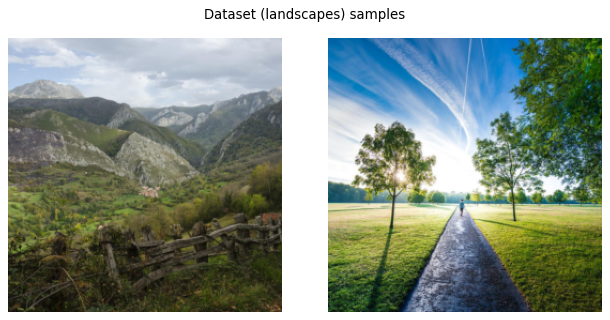

In [ ]:
def show_sample(lab_arrs: list, title: str):
    '''
    lab_arrs: list of ndarray with shape (width, height, 3) (RGB)
    '''

    nrows = len(lab_arrs) // 2
    fig = figure(figsize=(8, 4 * nrows), dpi=80, layout='constrained')
    fig.suptitle(title)
    subplots_adjust(wspace=2)
    for i, arr in enumerate(lab_arrs):
        arr = arr.astype(np.uint8) 
        img = Image.fromarray(arr)
        
        fig.add_subplot(nrows, 2, i + 1)
        imshow(img)
        axis('off')

    fig.get_layout_engine().set(w_pad=0.1, h_pad=0.1, hspace=0.1, wspace=0.02)

show_sample([small_train_dataset[8], small_train_dataset[10]], 'Dataset (landscapes) samples')

In [202]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

small_train_dataloader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
small_val_dataloader = DataLoader(small_val_dataset, batch_size=batch_size, shuffle=True)

device_name = "cuda" if torch.cuda.is_available() else "cpu"

In [212]:
warnings.filterwarnings("ignore", category=UserWarning)

class LayerReLU(nn.Module):
      def __init__(self, layer: nn.Module):
         super().__init__()
         self.layer = layer

      def forward(self, x):
         x = self.layer(x)
         relu = nn.ReLU()
         return relu(x)

class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()

    def forward(self, x):
        print(x.shape)
        return x

class BaseColorizer(nn.Module):
   def __init__(self):
      super().__init__()
      self.conv1 = LayerReLU(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1))
      self.conv2 = LayerReLU(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1))
      self.conv3 = LayerReLU(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1))
      self.conv4 = LayerReLU(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1))
      self.conv5 = LayerReLU(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1))
      self.conv6 = LayerReLU(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1))
      self.conv7 = LayerReLU(nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1))
      self.conv8 = LayerReLU(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1))
      self.conv9 = LayerReLU(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1))
      self.conv10 = LayerReLU(nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2))
      self.conv_transp = LayerReLU(nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1))
      self.conv11 = nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0)
      
      self.softmax = nn.Softmax(dim=1)
      self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
      self.upsample4 = nn.Upsample(scale_factor=8, mode='bilinear')

      self.seq = nn.Sequential(self.conv1,
                             self.conv2,
                             nn.BatchNorm2d(num_features=64),
                             self.conv3,
                             self.conv4,
                             nn.BatchNorm2d(num_features=128),
                             self.conv5,
                             self.conv6,
                             self.conv7,
                             nn.BatchNorm2d(num_features=256),
                             self.conv8,
                             self.conv9,
                             self.conv9,
                             nn.BatchNorm2d(num_features=512),
                             self.conv10,
                             self.conv10,
                             self.conv10,
                             nn.BatchNorm2d(num_features=512),
                             self.conv10,
                             self.conv10,
                             self.conv10,
                             nn.BatchNorm2d(num_features=512),
                             self.conv9,
                             self.conv9,
                             self.conv9,
                             nn.BatchNorm2d(num_features=512),
                             self.conv_transp,
                             self.conv6,
                             self.conv6,
                             self.conv11,
                             self.softmax,
                             self.model_out,
                             self.upsample4)
   
   def forward(self, input: np.ndarray):
      """Args:
            input: ndarray of shape (batch size, width, height, 3) (Lab color space)

        Returns:
             output (Ŷ): tensor of shape (batch size, width, height, 3) (Lab color space)
        """
      
      input_l_normalized = torch.tensor((input[:, :, :, 0:1] - 50) / 100, dtype=torch.float32).to(device_name)
      
      output_ab = self.seq(input_l_normalized.permute(0, 3, 1, 2))
      output_ab_unnormalized = output_ab * 255 # 110?
      return torch.cat((input_l_normalized * 100 + 50, output_ab_unnormalized.permute(0, 2, 3, 1)), 3)


In [189]:
max_ab_dist = np.linalg.norm([255, 255])

def accuracy(y_pred_ab: torch.tensor, y_true_ab: torch.tensor):
    accs = (max_ab_dist - np.linalg.norm((y_pred_ab - y_true_ab).cpu().detach().numpy(), axis=3)) / max_ab_dist
    return accs

In [206]:
def mse_loss_reward_ab_distance(output, target):
    c = 0.1
    norm = torch.linalg.vector_norm(output)
    loss = torch.mean((output - target)**2 / (c * (norm / max_ab_dist)))
    return loss

In [222]:
state_dict_mse_loss = torch.load('./base_model_mse_loss.ckpt', map_location=torch.device(device_name))
base_model_mse = BaseColorizer()
base_model_mse.load_state_dict(state_dict_mse_loss['model_state_dict'])

base_model_mse_dist_reward = BaseColorizer()
state_dict_mse_distance_reward = torch.load('./base_model_mse_loss_distance_reward.ckpt', map_location=torch.device(device_name))
base_model_mse_dist_reward.load_state_dict(state_dict_mse_distance_reward['model_state_dict'])

<All keys matched successfully>

In [ ]:
def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, lr, print_every
):
    print("Starting training")
    print(f"Train dataset length: {len(train_loader.dataset)}, val dataset length: {len(val_loader.dataset)}, image size: {image_size}, "
          + f"batch size: {train_loader.batch_size}/{val_loader.batch_size}, lr: {lr}, device: {device_name}")
    device = torch.device(device_name)
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss, train_acc = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}"
        )
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(
    model, optimizer, loss_fn, train_loader, val_loader, device, print_every
):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, rgb_y in enumerate(train_loader):
        lab_y = color.rgb2lab(rgb_y / 255)
        lab_y = torch.tensor(lab_y).to(device)
        y_ab = lab_y[:, :, :, 1:]
        optimizer.zero_grad()
        z = model.forward(lab_y)
        z_ab = z[:, :, :, 1:]
        loss = loss_fn(z, lab_y)
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        acc_batch_avg = accuracy(z_ab, y_ab).mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
                f"\tVal. acc.: {val_acc:.3f}"
            )

    return model, train_loss_batches, train_acc_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for _, rgb_y in enumerate(val_loader):
            lab_y = torch.tensor(color.rgb2lab(rgb_y / 255)).to(device)
            y_ab = lab_y[:, :, :, 1:]
            z = model.forward(lab_y)
            z_ab = z[:, :, :, 1:]
            batch_loss = loss_fn(z, lab_y)
            val_loss_cum += batch_loss.item()
            acc_batch_avg = accuracy(z_ab, y_ab).mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum / len(val_loader), val_acc_cum / len(val_loader)

In [ ]:
model = base_model_mse_dist_reward
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 10
loss_fn = mse_loss_reward_ab_distance
print_every = 1

if torch.cuda.is_available():
    torch.cuda.empty_cache()

model, train_losses, train_accs, val_losses, val_accs = training_loop(model, optimizer, loss_fn, train_dataloader, val_dataloader, num_epochs, lr, print_every)

Starting training
Train dataset length: 2818, val dataset length: 500, image size: 256, batch size: 64/64, lr: 0.001, device: cuda
	Batch 0/45: 	Train loss: 5.399, 	Train acc.: 0.951, 	Val. loss: 5.667, 	Val. acc.: 0.951
	Batch 1/45: 	Train loss: 6.342, 	Train acc.: 0.947, 	Val. loss: 5.682, 	Val. acc.: 0.951
	Batch 2/45: 	Train loss: 5.788, 	Train acc.: 0.951, 	Val. loss: 5.725, 	Val. acc.: 0.951
	Batch 3/45: 	Train loss: 5.281, 	Train acc.: 0.954, 	Val. loss: 5.669, 	Val. acc.: 0.951
	Batch 4/45: 	Train loss: 5.056, 	Train acc.: 0.954, 	Val. loss: 5.694, 	Val. acc.: 0.951
	Batch 5/45: 	Train loss: 6.437, 	Train acc.: 0.948, 	Val. loss: 5.673, 	Val. acc.: 0.951
	Batch 6/45: 	Train loss: 5.118, 	Train acc.: 0.954, 	Val. loss: 5.649, 	Val. acc.: 0.951
	Batch 7/45: 	Train loss: 5.220, 	Train acc.: 0.954, 	Val. loss: 5.608, 	Val. acc.: 0.952
	Batch 8/45: 	Train loss: 5.447, 	Train acc.: 0.954, 	Val. loss: 5.490, 	Val. acc.: 0.952
	Batch 9/45: 	Train loss: 4.222, 	Train acc.: 0.957, 	Val. 

In [214]:
def plot_model_results(model, train_dict, val_dict):
    model.eval()
    model.to(device_name)

    for i, dict_ in enumerate([train_dict, val_dict]):
        with torch.no_grad():
            imgs_lab = []
            for i in dict_['indices']:
                dataset = dict_['dataset']
                imgs_lab.append(dataset[i])
                colorized = model.forward(color.rgb2lab(np.array([dataset[i]]) / 255))[0]
                colorized_lab = color.lab2rgb(colorized.detach().cpu().numpy()) * 255
                imgs_lab.append(colorized_lab)
            show_sample(imgs_lab, dict_['title'])

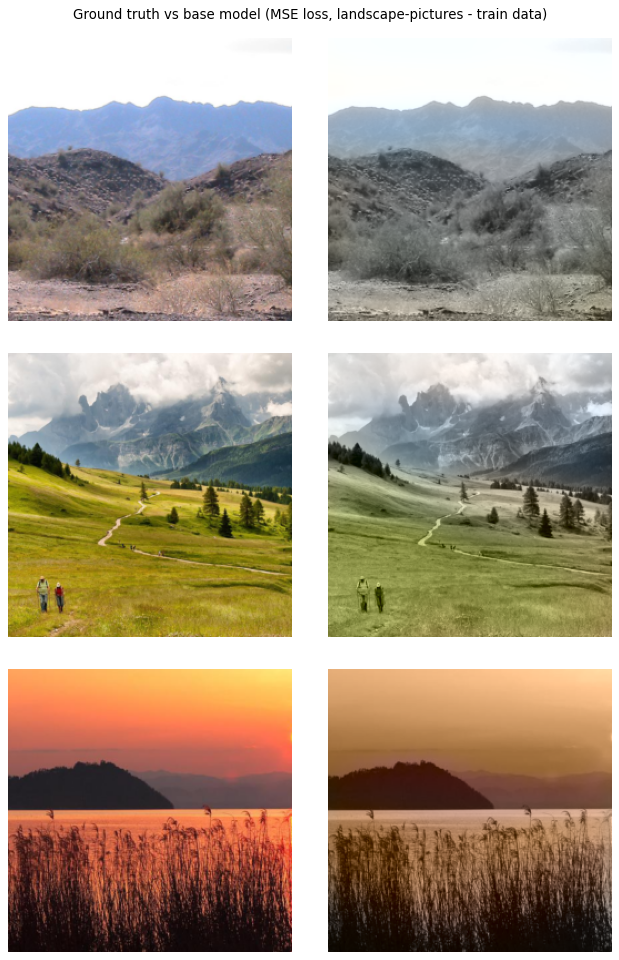

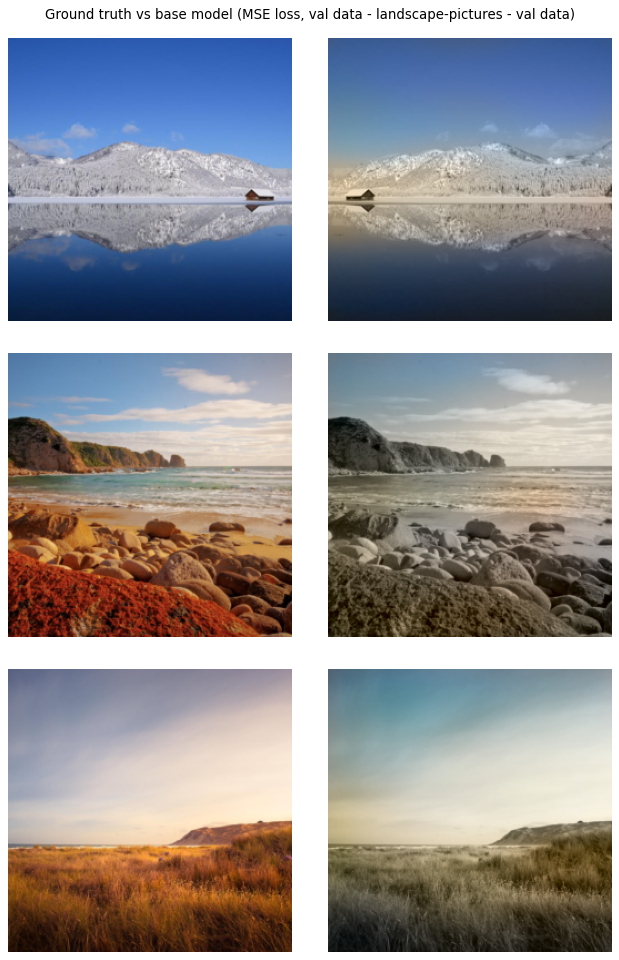

In [221]:
train_sample_indices = [3, 11, 18]
val_sample_indices = [53, 51, 58]

base_mse_train_dict = {
    'dataset': train_dataset,
    'indices': train_sample_indices,
    'title': 'Ground truth vs base model (MSE loss, landscape-pictures - train data)'
}
base_mse_val_dict = {
    'dataset': val_dataset,
    # 'indices': [33, 31, 38],
    'indices': val_sample_indices,
    'title': 'Ground truth vs base model (MSE loss, val data - landscape-pictures - val data)'
}

plot_model_results(base_model_mse, base_mse_train_dict, base_mse_val_dict)

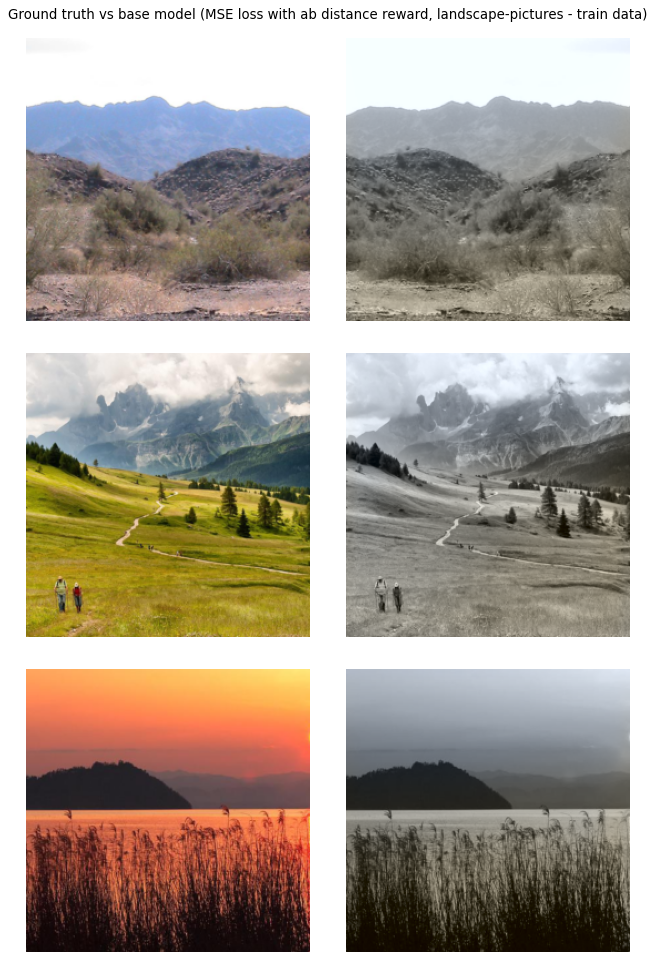

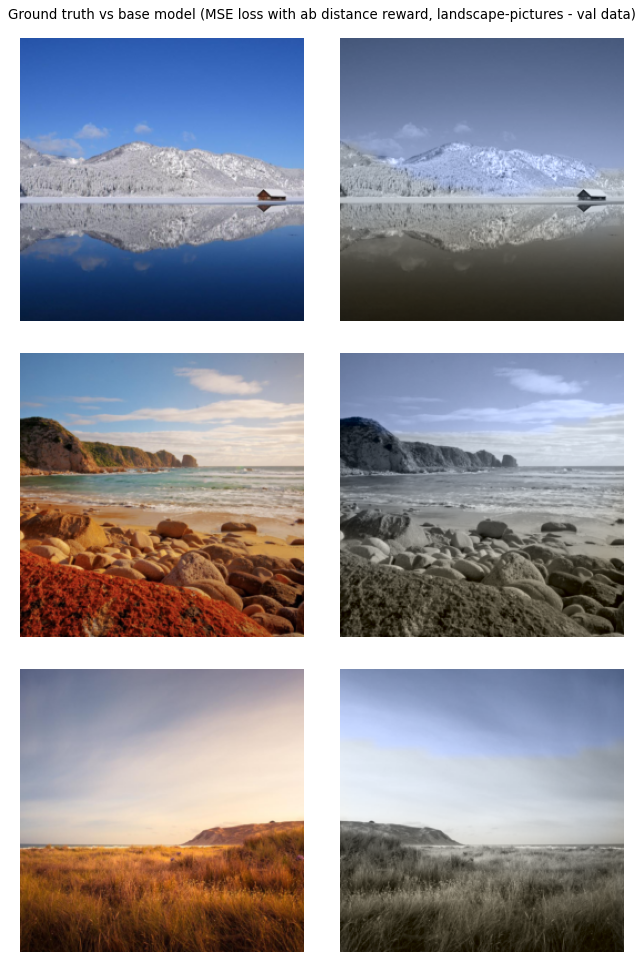

In [223]:
base_mse_dist_reward_train_dict = base_mse_train_dict.copy()
base_mse_dist_reward_train_dict['title'] = 'Ground truth vs base model (MSE loss with ab distance reward, landscape-pictures - train data)'

base_mse_dist_reward_val_dict = base_mse_val_dict.copy()
base_mse_dist_reward_val_dict['title'] = 'Ground truth vs base model (MSE loss with ab distance reward, landscape-pictures - val data)'

plot_model_results(base_model_mse_dist_reward, base_mse_dist_reward_train_dict, base_mse_dist_reward_val_dict)

In [ ]:
torch.save(
    {
        "model_state_dict": base_model_mse.state_dict(),
        "train_losses": train_losses,
        "train_accs": train_accs,
        "val_losses": val_losses,
        "val_accs": val_accs,
    },
    "./base_model_mse_loss_distance_reward.ckpt",
)